# Tuto 001 : HBM vs time integration
In this tutorial are briefly presented two methods to solve nonlinear dynamics problems, namely the Harmonic Balance Method and time integration. Then, both methods will be applied to find the periodic solutions of a Duffing oscillator, and their results will be compared. 


In [1]:
## This block makes the mandatory imports and configure matplotlib for figures
import sys
PATH_TO_PYHARM = False
PATH_TO_PYHARM = "../" ## to be updated
if PATH_TO_PYHARM !=False : 
    sys.path.append(PATH_TO_PYHARM)
# ------------------ IMPORTS ------------------ #
import copy
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pyHarm
import json
import scipy.io
from pyHarm.Elements.FactoryElements import ElementDictionary
from pyHarm.Elements.ABCElement import ABCElement

## Duffing oscillator

\begin{equation}
y'' + \delta \cdot y' + \alpha \cdot y + \beta \cdot y^3 = \gamma \cdot \sin(\omega t)
\end{equation}


# HBM analysis 

The harmonic balance method is a frequency domain method which allows to find the steady-state solutions of nonlinear differential equations. Its main idea consists in expressing the displacements, nonlinear forces, and excitation forces as truncated Fourier series. 

\begin{equation}
u(t) = \sum_{n=1}^{N} a_n \cos(n \omega t) + b_n \sin(n \omega t)
\end{equation}

By doing so, and after grouping the coefficients for each harmonic, the nonlinear differential equation is replaced by a set of nonlinear algebraic equations which can be solved using iterative Newton-Raphson like procedures.

By definition of the method, the transient phase is 'by-passed' and does not need to be computed, which is key to make the HBM a much faster alternative to time integration. One of its drawbacks, in its classical form, is that it does not allow to capture quasi-periodic and chaotic motions, which is possible with time integration.

One of the main parameters of the method is the truncation order N. It controls both the computation cost and the accurary of the method. It is worth emphasazing that, provided the contributing harmonics are kept in the Fourier expansion, the HBM method gives an excellent approximation of the nonlinear solutions.

A special treatment is necessary for the nonlinear forces. Although the nonlinear solver solves for the Fourier coefficients, it is necessary to go to the time domain through a procedure called alternating frequency time (AFT). The Fourier coefficients of the displacement are converted into the time domain using an inverse Fourier transform. This allows to calculate explicity the nonlinear forces. Once calculated, these forces are converted back to the frequency domain by means of a Fourier transform. This AFT procedure is covered in Tuto_002_AFTscheme.ipynb.

<u> Remark </u>: Despite this procedure, the HBM method remains a frequency domain analysis, and bears no resemblance with the time integration methods.

## pyHarm model and inputs for FRF analysis

In [2]:
 # ------------------ SYSTEM CONSTRUCTION ------------------ #
m = 1.0 # mass
delta = 0.3 # damping
alpha = 1 # stiffness
beta = 1 # cubic term stiffness
gamma = 1.0 # forcing amplitude

MassMatrix = np.array([[m]])
DampMatrix = np.array([[delta]])
RigidMatrix = np.array([[alpha]])
LinSys = dict()
LinSys["M"] = MassMatrix
LinSys["C"] = DampMatrix
LinSys["K"] = RigidMatrix
LinSys["G"] = 0 * MassMatrix

# ------------------ INPUT CONSTRUCTION ------------------ #
INP = {
    "analysis": {
        "FRF": {
            "study": "frf",
            "puls_inf": 0.01,
            "puls_sup": 2.5,
            "ds0": 0.01,
            "ds_min": 1e-12,
            "ds_max": 0.01,
            "sign_ds": 1,
            "verbose": False,
            "stepsizer": "acceptance",
            "predictor": "tangent",
            "predictor_options": {
                "verbose": False
            },
            "corrector": "arc_length",
            "preconditioner": "nopreconditioner",
            "stopper": "bounds",
            "solver": "scipyroot"
        }
    },
    "system": {
        "type": "Base",
        "nh": 7,             # number of harmonics to be considered [int]
        "nti": 2048,         # number of time steps.
        "adim": {            # Parameters used for adimensionalising the system [dict[bool,float,float]]
            "status": False, # If True the system will be adimensionalised
            "lc": 1.0,       # length characteristic
            "wc": 1.0        # frequency characteristic
        }
    },
    "substructures": {
        "sub1": {
            "matrix": LinSys,
            "ndofs": 1
        }
    },
    "connectors": {
        "loading": {
            "type": "CosinusForcing",
            "connect": {
                "sub1": [0]},
            "dirs": [0],
            "amp": gamma
        },
        "cubic": {
            "type": "CubicSpring",
            "connect": {
                "sub1": [0]},
            "dirs": [0],
            "k": beta
        }
    }
}

## pyHarm FRF computation for different values of nh

In [8]:
omegas = dict()
amplitudes = dict()
times = dict()
sols = dict()
list_nh = np.arange(1,15,2)
# list_nh = np.array([1])
for nh in list_nh:
    INP['system']['nh'] = nh
    NRB_NH = pyHarm.Maestro(INP) # construit le system 
    indices_selection = ("sub1",0,0) 
    indexH = NRB_NH.getIndex(*indices_selection) # trouve l'indice 
    print("indexH", indexH, f"At n_H = {nh}")
    # Solve
    start = time.time()
    NRB_NH.operate() # effectue le code 
    elapsed_time = time.time()-start
    # nls = Non linear system
    # Retrieve solutions
    SA = [sol for sol in NRB_NH.nls["FRF"].SolList if sol.flag_accepted]

    om = np.array([sol.x[-1] for sol in SA])

    elem = NRB_NH.nls["FRF"].system.LE_nonlinear_nodlft[0] # non linear sytem
    SA_X = np.concatenate([sol.x.reshape(-1,1) for sol in SA ],axis=1)
    print("SA_X.shape()", SA_X.shape)
    a_max = []
    for i in range(len(om)):
        X_TIME = SA_X[indexH,i] @ elem.D["ft"] # temporal a frequenuicel discret fourier transform
        a_max.append(np.max(X_TIME))
    # Store solutions
    sols[nh] = SA_X
    times[nh] = elapsed_time
    omegas[nh] = om
    amplitudes[nh] = a_max

indexH [0 1 2] At n_H = 1
[-1.58947107e-19  6.02320516e-03  1.53722440e-01  9.88095710e-01]
[3.26249744e-18 1.19745566e-02 1.53832951e-01 9.88024308e-01]
[-1.70445392e-18  1.79253934e-02  1.54016589e-01  9.87905649e-01]
[2.17800390e-18 2.38754506e-02 1.54273413e-01 9.87739681e-01]
[1.90362294e-18 2.98244527e-02 1.54603504e-01 9.87526333e-01]
[-1.90556725e-18  3.57721099e-02  1.55006966e-01  9.87265515e-01]
[1.27810518e-18 4.17181145e-02 1.55483927e-01 9.86957115e-01]
[-3.98343787e-18  4.76621375e-02  1.56034533e-01  9.86601006e-01]
[4.29956224e-18 5.36038253e-02 1.56658954e-01 9.86197040e-01]
[1.85224313e-18 5.95427959e-02 1.57357379e-01 9.85745054e-01]
[4.16656147e-18 6.54786360e-02 1.58130018e-01 9.85244866e-01]
[2.58898140e-18 7.14108972e-02 1.58977099e-01 9.84696281e-01]
[1.81987618e-18 7.73390931e-02 1.59898867e-01 9.84099089e-01]
[6.66966871e-19 8.32626960e-02 1.60895584e-01 9.83453067e-01]
[6.27567884e-18 8.91811337e-02 1.61967527e-01 9.82757979e-01]
[3.14984260e-18 9.50937867e-

     | sub  | harm | cs | node_num | dof_num | PoM | NL | KC |
     |------|------|----|----------|---------|-----|----|----|
     | sub1 | 0    | c  | 0        | 0       | p   | 1  | 0  |
     | sub1 | 1    | c  | 0        | 0       | p   | 1  | 0  |
     | sub1 | 1    | s  | 0        | 0       | p   | 1  | 0  |
     CS (CoordinateSystem): local or global coordinate system the kinematic condition is defined on.
     return "Element of type {self.__class__.__name__} that links :\n - {self.sub} substructure {} \n to\n - {self.node_of_node} node of {self.sub_of_node} substructure"

## Plot FRFs

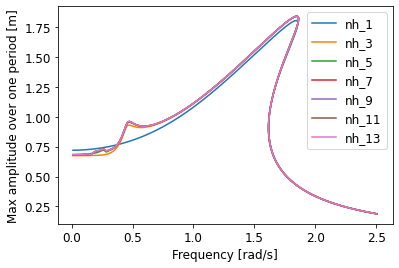

In [6]:
for nh in list_nh:
    plt.plot(omegas[nh], amplitudes[nh])
_ = plt.legend(['nh_'+str(i) for i in list_nh], fontsize=12)
_ = plt.xlabel('Frequency [rad/s]', fontsize=12)
_ = plt.ylabel('Max amplitude over one period [m]', fontsize=12)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

The FRF curves exhibit several features: 
- a softening effect is observed (the curve is slanted on the right hand side)
- Two turning points are observed. These correspond to the transition between stable and unstable periodic solutions. 
- while 3 harmonics appear to be enough to accurately capture the maximum response over the considered frequency range, more harmonics are needed to capture the smaller peaks. 

## Exercice #1
Post-process the results stored in SA to show the harmonic content of the response for each peak using bar graphs. You should be able to note the predominance of the odd harmonics over the even harmonics. 

# Time integration

Similar to the HBM method, time integration methods are methods used to find numerical <u>approximation</u> to the solutions of ordinary different equations (ODE). 

We are typically solving first-order ODE which is an initial value problem in the following form:

\begin{equation}
{y}'(t) = f(t, y(t)), y(t_0)=y_0
\end{equation}

The most basic and explicit method to solve this ODE is the Euler method, or the Forward Euler method. It consists in finding an approximation of a point on the curve by moving a short distance along the tangent to the curve, which is expressed by the following equation:

\begin{equation}
y_{n+1}=y_n+hf(t_n,y_n)
\end{equation}

The Forward Euler method is a first order method that belongs to the more general explicit Runge-Kutta methods. The most popular one among them is the 4th order method RK4:

\begin{equation}
y_{n+1}=y_n+\frac{h}{6}(k_1+2k_2+2k_3+k_4)
\end{equation}

where

\begin{equation}
\left\{
\begin{matrix}
k_1 = f(t_n, y_n)\\ 
k_2 = f(t_n+\frac{h}{2}, y_n+h\frac{k_1}{2})\\ 
k_3 = f(t_n+\frac{h}{2}, y_n+h\frac{k_2}{2})\\ 
k_4 = f(t_n+h, y_n+hk_3)
\end{matrix}\right.
\end{equation}

Instead of using a single increment and a single slope, as in the Euler scheme, the RK4 consists in using a weighted average of 4 different increments, each increment being the product of the interval length h and an estimated slope.

The Runge-Kutta 45 (a.k.a RK45 or RKF45) method, which is the default option of the scipy.integrate.solve_ivp function, goes even further with 6 different increments, which allows a more accurate estimation of the solution at each step. 

By introducing u = [y', y], the equation of motion of the duffing oscillator can be formulated as a first order ODE, defined in the function below.

In [7]:
def duffing(t, u, omega):
    return (u[1], -delta*u[1]-alpha*u[0]-beta*u[0]**3+gamma*np.sin(omega*t))

In [8]:
from scipy.integrate import solve_ivp
def time_integration(func, omega, y0, nit, n_period):
    ts = np.linspace(0, n_period * 2*np.pi / omega, n_period * nit)
    t_span = (ts[0], ts[-1]) 
    us = solve_ivp(func, t_span, y0, args=(omega,), method='RK45', t_eval=ts, atol=1e-9, rtol=1e-9)
    if us.success == False:
        raise ValueError('The time integration failed')
    return ts, us.y[0,:], us.y[1,:]

## Exercice #2
In order to go beyond the transient phase, and reach the steady state, it is necessary to integrate the response over a number of periods, that will be denoted n_period. The goal of this second exercice is to determine the minimum value of n_period that allows to reach the steady state, for all values of omega. 

## Compute TI results for all values of omega

In [9]:
y0 = [1.0,0.0]
nit = 2048
n_period = 25

t_all = []
y_all = []
y_dot_all = []

om = np.linspace(INP['analysis']['FRF']['puls_inf'], INP['analysis']['FRF']['puls_sup'], len(omegas[13]))
start = time.time()
for omega in om:
    t, y, y_dot = time_integration(duffing, omega, y0, nit, n_period)
    
    # ------------------------
    # Update initial conditions
    # ------------------------
    y0[0] = y[-nit]
    y0[1] = y_dot[-nit]
    
    t_all.append(t)
    y_all.append(y)
    y_dot_all.append(y_dot)
print('Elapsed wall clock time: ', time.time()-start)

Elapsed wall clock time:  409.74535608291626


## Plot FRF from TI results

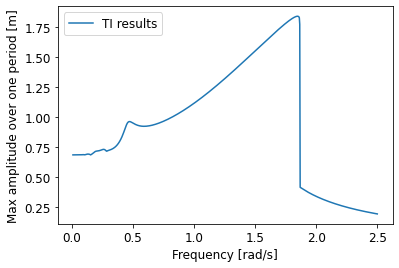

In [10]:
a_max = []
for y in y_all:
    a_max.append(np.max(y[-nit:]))
plt.plot(om, a_max)
_ = plt.legend(['TI results'], fontsize=12)
_ = plt.xlabel('Frequency [rad/s]', fontsize=12)
_ = plt.ylabel('Max amplitude over one period [m]', fontsize=12)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

A jump phenomenon can be observed in the FRF near the turning point. This is expected since the time integration can only capture the stable solutions. As a result, in order to capture the stable solutions in full, and reproduce the results obtained using the HBM, it is necessary to complete a sweep-down analysis.  

### Compute TI results for all values of omega - sweep-down

In [11]:
y0 = [1.0,0.0]
nit = 2048
n_period = 25

t_all_down = []
y_all_down = []
y_dot_all_down = []

om = np.linspace(INP['analysis']['FRF']['puls_inf'], INP['analysis']['FRF']['puls_sup'], len(omegas[11]))
start = time.time()
for omega in np.flip(om):
    t, y, y_dot = time_integration(duffing, omega, y0, nit, n_period)
    
    # ------------------------
    # Update initial conditions
    # ------------------------
    y0[0] = y[-nit]
    y0[1] = y_dot[-nit]
    
    t_all_down.append(t)
    y_all_down.append(y)
    y_dot_all_down.append(y_dot)
print('Elapsed wall clock time: ', time.time()-start)

Elapsed wall clock time:  3267.151245355606


## Plot FRF from TI results - sweep-up & sweep-down

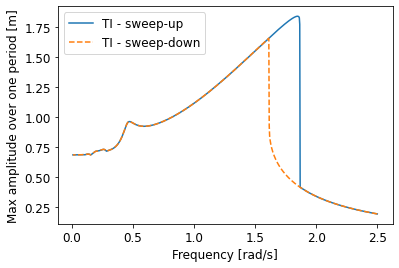

In [12]:
a_max = []
a_max_down = []
for y in y_all:
    a_max.append(np.max(y[-nit:]))
for y in y_all_down: 
    a_max_down.append(np.max(y[-nit:]))
plt.plot(om, a_max)
plt.plot(np.flip(om), a_max_down, '--')
_ = plt.legend(['TI - sweep-up', 'TI - sweep-down'], fontsize=12)
_ = plt.xlabel('Frequency [rad/s]', fontsize=12)
_ = plt.ylabel('Max amplitude over one period [m]', fontsize=12)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

## Harmonic content of the time signal @ each peak

In [ ]:
from numpy.fft import fft, fftfreq
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

def compute_fft(signal, omega, N_harm_max=10, plot=False):
    nit = len(signal)
    ts = np.linspace(0, 2*np.pi / omega, nit)
    fs = omega/2/np.pi # signal fundamental frequency 

    # Number of times to duplicate the signal : necessary to improve the FFT accuracy
    N = 100
    extended_t = np.concatenate([ts + i * (ts[-1] - ts[0]) for i in range(N)])
    extended_signal = np.tile(signal, N)

    # Signal sampling
    Duree = N*2*np.pi/omega  # Signal duration in seconds
    Te = 2*np.pi/omega / 2 / N_harm_max   # Sampling period - cf. Shannon criterion
    N = int(Duree/Te) + 1  # Number of points of the sampled signal
    te = np.linspace(0, Duree, N, endpoint=False)  
    x_e = interp1d(extended_t, extended_signal, kind='linear')(te)

    # FFT
    X = fft(x_e)  # Fourier transform
    freq = fftfreq(x_e.size, d=Te)  # Frequencies of the FFT

    # On prend la valeur absolue de l'amplitude uniquement pour les fréquences positives
    X_abs = np.abs(X[:N//2])
    phase = np.angle(X[:N//2])
    # Amplitude normalization
    X_norm = X_abs*2.0 / N
    # We only keep positive frequencies
    freq_pos = freq[:N//2]

    peaks, _ = find_peaks(X_norm, height=0.001*np.max(X_norm))

    if plot: 
        plt.plot(freq_pos[peaks]/fs, X_norm[peaks], 'o')
        plt.plot(freq_pos/fs, X_norm, label="Amplitude absolue")
        plt.grid()
        plt.xlabel(r"Normalized frequency", fontsize=10)
        plt.ylabel(r"Amplitude $|X(f)|$", fontsize=10)
        plt.title("Fourier transform", fontsize=12)
        custom_xticks = np.arange(0, N_harm_max+1, 1)
        plt.xticks(custom_xticks, fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()

    return np.ceil(freq_pos[peaks]/fs), X_norm[peaks]

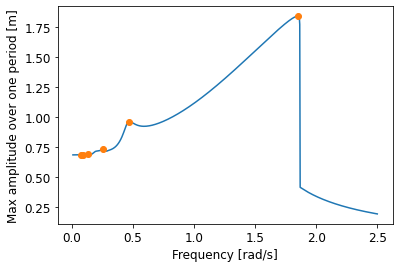

In [14]:
a_max = np.array(a_max)
peaks, _ = find_peaks(a_max)
plt.plot(om, a_max)
plt.plot(om[peaks], a_max[peaks],'o')
_ = plt.xlabel('Frequency [rad/s]', fontsize=12)
_ = plt.ylabel('Max amplitude over one period [m]', fontsize=12)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

In [15]:
nit = 2048
y0 = [1.0,0.0]
for i in range(len(peaks)):
    omega = om[peaks[i]]
    _, y, _ = time_integration(duffing, omega, y0, nit, n_period)
    freq, amp = compute_fft(y[-nit:], omega, 15) # To only display the harmonics number
    # freq, amp = compute_fft(y[-nit:], omega, 15, True) # To visualize FFT results 
    print(freq)

[ 1.  3.  5.  7.  9. 11.]
[ 1.  3.  5.  7.  9. 11. 13.]
[ 1.  3.  5.  7.  9. 11. 13.]
[1. 3. 5. 7. 9.]
[1. 3. 5. 7. 9.]
[1. 3.]


The analysis of the harmonic content of each peak of the time integration results show that the odd harmonics are predominant in the response. The number of harmonics listed above depends on the threshold 'height' defined in the find_peaks function. A relative value of 0.1% percent of the maximum contributing term in the FFT was defined here. With this value, it is found that up to 13 harmonics are necessary to accurately capture all the peaks of TI response. Based on this finding, the results obtained with HBM, using 13 harmonics, are plotted against the time integration results in the figure below. The excellent match confirms the analysis. This also confirms that, provided enough harmonics are used, the HBM results provide an excellent approximation of the time integration results. 

## Plot FRF - TI and HBM results together 

In [16]:
plt.plot(om, a_max)
plt.plot(np.flip(om), a_max_down)
plt.plot(omegas[13], amplitudes[13], 'k--')
_ = plt.legend(['TI - sweep-up', 'TI - sweep-down', 'HBM - nh=13'], fontsize=12)
_ = plt.xlabel('Frequency [rad/s]', fontsize=12)
_ = plt.ylabel('Max amplitude over one period [m]', fontsize=12)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

## Comments on the computational cost

In [17]:
import pandas as pd

data_HBM = {'HBM - nh=': list_nh,
        'CPU time [s]': times.values()}

df_HBM = pd.DataFrame(data_HBM)
print(df_HBM)

data_TI = {'TI - sweep-up': [669.97], 'TI - sweep-down': [556.54]}

df_TI = pd.DataFrame(data_TI)
print(df_TI)

   HBM - nh=  CPU time [s]
0          1      2.673687
1          3      2.185295
2          5      2.455394
3          7      3.653113
4          9      3.745893
5         11      4.232589
6         13      4.326208
   TI - sweep-up  TI - sweep-down
0         669.97           556.54


Two sweeps are needed for the time integration to capture all the stable solutions over the frequency range. By taking the same number of frequency increments, and even considering only one frequency sweep, the HBM is hundreds of times faster than time integration.

Notes: 

- This is not claimed to be the fastest available time integration method to date. The reader is encouraged to test the other available methods supported by the solve_ivp function.
- For stronger nonlinearities, such as 2D frictional gaps, the number of periods needed to reach the steady-state during the time integration can be much higher.